In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder, TargetEncoder
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from imblearn.over_sampling import SMOTE
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, GRU, RNN, SimpleRNN, Dropout, LeakyReLU, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import SwapEMAWeights,Callback
from tensorflow.keras.saving import save_model, load_model

In [2]:
# Carregar o conjunto de dados
train_data = pd.read_csv(r'dataset\train.csv')
test_data = pd.read_csv(r'dataset\test.csv')

train_data.head()

,id,annual_income,debt_to_income_ratio,credit_score,loan_amount,interest_rate,gender,marital_status,education_level,employment_status,loan_purpose,grade_subgrade,loan_paid_back
0,0,29367.99,0.084,736,2528.42,13.67,Female,Single,High School,Self-employed,Other,C3,1.0
1,1,22108.02,0.166,636,4593.10,12.92,Male,Married,Master's,Employed,Debt consolidation,D3,0.0
2,2,49566.20,0.097,694,17005.15,9.76,Male,Single,High School,Employed,Debt consolidation,C5,1.0
3,3,46858.25,0.065,533,4682.48,16.10,Female,Single,High School,Employed,Debt consolidation,F1,1.0
4,4,25496.70,0.053,665,12184.43,10.21,Male,Married,High School,Employed,Other,D1,1.0


In [3]:
# 1. Defina o dicionário de mapeamento
mapa_colunas = {
    'id': 'id_cliente',
    'annual_income': 'renda_anual',
    'debt_to_income_ratio': 'razao_divida_renda',
    'credit_score': 'score_credito',
    'loan_amount': 'valor_emprestimo',
    'interest_rate': 'taxa_juros',
    'gender': 'genero',
    'marital_status': 'status_civil',
    'education_level': 'nivel_escolaridade',
    'employment_status': 'status_emprego',
    'loan_purpose': 'proposito_emprestimo',
    'grade_subgrade': 'grau_subgrau',
    'loan_paid_back': 'emprestimo_quitado'
}

# Aplique a renomeação no DataFrame, usando inplace=True para modificar o DF original
train_data.rename(columns=mapa_colunas, inplace=True)
test_data.rename(columns=mapa_colunas, inplace=True)

train_data.set_index('id_cliente', inplace=True)
test_data.set_index('id_cliente', inplace=True) 

In [4]:
test_data.head()

,renda_anual,razao_divida_renda,score_credito,valor_emprestimo,taxa_juros,genero,status_civil,nivel_escolaridade,status_emprego,proposito_emprestimo,grau_subgrau
id_cliente,,,,,,,,,,,
593994,28781.05,0.049,626,11461.42,14.73,Female,Single,High School,Employed,Other,D5
593995,46626.39,0.093,732,15492.25,12.85,Female,Married,Master's,Employed,Other,C1
593996,54954.89,0.367,611,3796.41,13.29,Male,Single,Bachelor's,Employed,Debt consolidation,D1
593997,25644.63,0.110,671,6574.30,9.57,Female,Single,Bachelor's,Employed,Debt consolidation,C3
593998,25169.64,0.081,688,17696.89,12.80,Female,Married,PhD,Employed,Business,C1


In [ ]:
# Mapeamento dos novos tipos
novos_tipos = {
    # 'id_cliente': 'int64',
    'renda_anual': 'float64',
    'razao_divida_renda': 'float64',
    'score_credito': 'int64',
    'valor_emprestimo': 'float64',
    'taxa_juros': 'float64',
    'genero': 'category',
    'status_civil': 'category',
    'nivel_escolaridade': 'category',
    'status_emprego': 'category',
    'proposito_emprestimo': 'category',
    'grau_subgrau': 'category',
    'emprestimo_quitado': 'int64'
}

# Aplicando a mudança em várias colunas de uma vez
train_data = train_data.astype(novos_tipos)
# test_data = test_data.astype(novos_tipos)

<Axes: xlabel='emprestimo_quitado', ylabel='valor_emprestimo'>

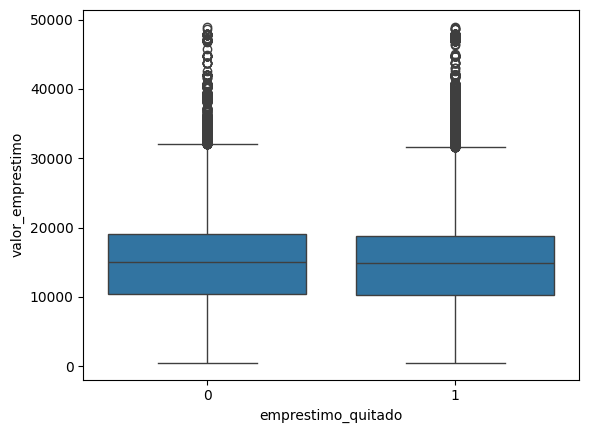

In [7]:
# sns.countplot(x = 'education_level', hue = 'loan_paid_back', data = train_data)
sns.boxplot(x = 'emprestimo_quitado', y = 'valor_emprestimo', data = train_data)

In [8]:
X_dummi = pd.get_dummies(train_data[['genero','status_civil','nivel_escolaridade','status_emprego','proposito_emprestimo','grau_subgrau']])
X_dummi.head()

,genero_Female,genero_Male,genero_Other,status_civil_Divorced,status_civil_Married,status_civil_Single,status_civil_Widowed,nivel_escolaridade_Bachelor's,nivel_escolaridade_High School,nivel_escolaridade_Master's,...,grau_subgrau_E1,grau_subgrau_E2,grau_subgrau_E3,grau_subgrau_E4,grau_subgrau_E5,grau_subgrau_F1,grau_subgrau_F2,grau_subgrau_F3,grau_subgrau_F4,grau_subgrau_F5
id_cliente,,,,,,,,,,,,,,,,,,,,,
0,True,False,False,False,False,True,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False
1,False,True,False,False,True,False,False,False,False,True,...,False,False,False,False,False,False,False,False,False,False
2,False,True,False,False,False,True,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False
3,True,False,False,False,False,True,False,False,True,False,...,False,False,False,False,False,True,False,False,False,False
4,False,True,False,False,True,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False


In [ ]:
X = train_data[['renda_anual','razao_divida_renda','score_credito','valor_emprestimo','taxa_juros']]

X = X.join(X_dummi)

X.head()

,renda_anual,razao_divida_renda,score_credito,valor_emprestimo,taxa_juros,genero_Female,genero_Male,genero_Other,status_civil_Divorced,status_civil_Married,...,grau_subgrau_E1,grau_subgrau_E2,grau_subgrau_E3,grau_subgrau_E4,grau_subgrau_E5,grau_subgrau_F1,grau_subgrau_F2,grau_subgrau_F3,grau_subgrau_F4,grau_subgrau_F5
id_cliente,,,,,,,,,,,,,,,,,,,,,
0,29367.99,0.084,736,2528.42,13.67,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,22108.02,0.166,636,4593.10,12.92,False,True,False,False,True,...,False,False,False,False,False,False,False,False,False,False
2,49566.20,0.097,694,17005.15,9.76,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,46858.25,0.065,533,4682.48,16.10,True,False,False,False,False,...,False,False,False,False,False,True,False,False,False,False
4,25496.70,0.053,665,12184.43,10.21,False,True,False,False,True,...,False,False,False,False,False,False,False,False,False,False


In [23]:
# X = train_data[['renda_anual','razao_divida_renda','score_credito','valor_emprestimo','taxa_juros']]

# 2. PADRONIZE APENAS AS COLUNAS NUMÉRICAS E CONVERTA DE VOLTA PARA DATAFRAME
scaler = StandardScaler()
X_numerico_scaled = scaler.fit_transform(train_data[['renda_anual','razao_divida_renda','score_credito','valor_emprestimo','taxa_juros']])

# Converta o array NumPy de volta para um DataFrame, mantendo o índice original
# Isso é crucial para a união na próxima etapa
X_numerico_scaled = pd.DataFrame(
    X_numerico_scaled, 
    columns=['renda_anual','razao_divida_renda','score_credito','valor_emprestimo','taxa_juros'],
    index=train_data.index # Garante a manutenção do índice
)

# 3. CONCATENE OS DADOS PADRONIZADOS COM AS DUMMY VARIABLES (X_dummi)
# Assume-se que X_dummi é um DataFrame e que 'train_data' é o DataFrame original.
# Se X_dummi foi criado a partir de train_data, o índice deve ser o mesmo.
X = pd.concat([X_numerico_scaled, X_dummi], axis=1)
Y = train_data['emprestimo_quitado']

X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.2, random_state=42, stratify=Y
)

In [25]:
# --- 4. Cálculo dos Pesos de Classe para Desbalanceamento ---

# Calcula os pesos inversamente proporcionais à frequência.
# Isso garante que o erro na classe minoritária seja mais penalizado.
class_weights = class_weight.compute_class_weight(
    'balanced',
    classes=np.unique(Y_train),
    y=Y_train
)
# Converte o array para o formato de dicionário exigido pelo Keras/TensorFlow
class_weight_dict = dict(enumerate(class_weights))

In [ ]:
# 1. Inicializa o SMOTE
# random_state garante que os resultados sejam reproduzíveis
smote = SMOTE(random_state=42)

# 2. Aplica o oversampling
# O fit_resample faz o aprendizado e a geração de novas amostras em um único passo.
X_train_smote, y_train_smote = smote.fit_resample(X_train, Y_train)

In [55]:
# steps = X_train.shape[1]

model = Sequential()
model.add(Input(shape=X_train.shape[1:]))
model.add(Dense(256, activation='tanh'))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.03))
model.add(Dense(32, activation=LeakyReLU(alpha=0.5)))
model.add(Dropout(0.03))
model.add(Dense(1,activation='sigmoid'))

model.compile(
    optimizer='adam',
    loss='binary_crossentropy', 
    metrics=['accuracy']        
)

c:\Users\lucas\OneDrive - Amelyer Company\Documentos\Projetos Python\Previsão do Reembolso do Empréstimo\.venv\Lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


In [56]:
# 4. Treinar o modelo com o callback
validation = model.fit(
    X_train_smote, y_train_smote,
    validation_data=(X_test, Y_test),
    epochs=10,
    batch_size=32
    # class_weight=class_weight_dict
)

Epoch 1/10
23725/23725 ━━━━━━━━━━━━━━━━━━━━ 57s 2ms/step - accuracy: 0.8683 - loss: 0.2904 - val_accuracy: 0.8827 - val_loss: 0.2982
Epoch 2/10
23725/23725 ━━━━━━━━━━━━━━━━━━━━ 58s 2ms/step - accuracy: 0.8747 - loss: 0.2761 - val_accuracy: 0.8871 - val_loss: 0.2976
Epoch 3/10
23725/23725 ━━━━━━━━━━━━━━━━━━━━ 67s 3ms/step - accuracy: 0.8754 - loss: 0.2743 - val_accuracy: 0.8781 - val_loss: 0.3067
Epoch 4/10
23725/23725 ━━━━━━━━━━━━━━━━━━━━ 67s 3ms/step - accuracy: 0.8759 - loss: 0.2732 - val_accuracy: 0.8757 - val_loss: 0.3030
Epoch 5/10
23725/23725 ━━━━━━━━━━━━━━━━━━━━ 67s 3ms/step - accuracy: 0.8767 - loss: 0.2721 - val_accuracy: 0.8726 - val_loss: 0.3165
Epoch 6/10
23725/23725 ━━━━━━━━━━━━━━━━━━━━ 67s 3ms/step - accuracy: 0.8769 - loss: 0.2713 - val_accuracy: 0.8797 - val_loss: 0.3004
Epoch 7/10
23725/23725 ━━━━━━━━━━━━━━━━━━━━ 67s 3ms/step - accuracy: 0.8771 - loss: 0.2703 - val_accuracy: 0.8762 - val_loss: 0.3089
Epoch 8/10
23725/23725 ━━━━━━━━━━━━━━━━━━━━ 70s 3ms/step - accuracy: 

In [57]:
model.evaluate(X_test, Y_test)

3713/3713 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.8851 - loss: 0.2965


[0.2964640259742737, 0.8851252794265747]

3713/3713 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step


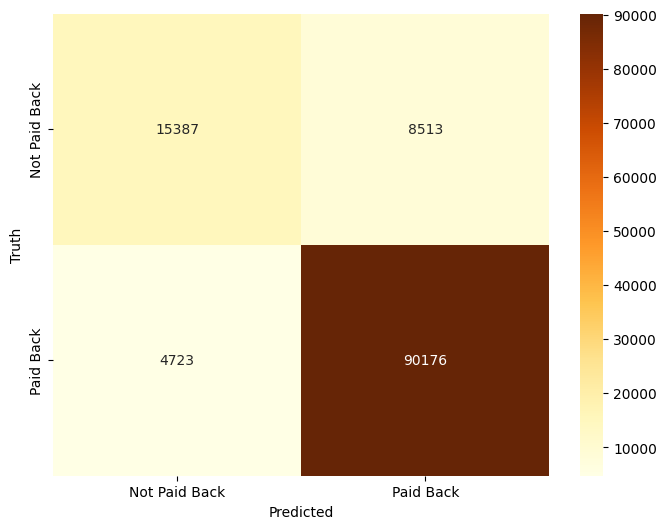

In [53]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

preds = model.predict(X_test)

# Converting probabilities to binary classes (0 or 1)
# The threshold 0.5 is standard for binary classification with a sigmoid activation
preds_classes = (preds > 0.5).astype(int)
# preds_classes
true_labels = Y_test.values

# true_labels.values.ravel()

cm = confusion_matrix(true_labels, preds_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='YlOrBr', 
            xticklabels=['Not Paid Back', 'Paid Back'], 
            yticklabels=['Not Paid Back', 'Paid Back'])
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()